In [ ]:
from dask.distributed import Client

# Create a local cluster using all CPU cores
client = Client()

# Optional: See dashboard link for live task monitoring  
print(client.dashboard_link)  


http://127.0.0.1:8787/status


Task exception was never retrieved
future: <Task finished name='Task-197' coro=<Client._gather.<locals>.wait() done, defined at /home/leochaussy/anaconda3/envs/dfg/lib/python3.11/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/home/leochaussy/anaconda3/envs/dfg/lib/python3.11/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


In [2]:
import dask.dataframe as dd

# Read large CSV file using Dask
df = dd.read_csv("./QUOT_SIM2_previous-2020-202507.csv", sep=";")
# Trigger a computation to make sure everything works
print(df.head())


2025-08-06 14:44:08,502 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('read-csv-dd4acb55572df170c67bd61069aa26fa', 0))" coro=<Worker.execute() done, defined at /home/leochaussy/anaconda3/envs/dfg/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError


KeyboardInterrupt: 

2025-08-06 14:44:10,503 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2025-08-06 14:44:10,503 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-08-06 14:44:10,504 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-08-06 14:44:10,504 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/leochaussy/anaconda3/envs/dfg/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leochaussy/anaconda3/envs/dfg/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
         

In [ ]:
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Point
import folium

# Step 1: Load data
df = dd.read_csv("./QUOT_SIM2_previous-2020-202507.csv", sep=";")

# Step 2: Filter for proximity to a given point
target_x, target_y, tolerance = 8945.1535, 20500.2147, 40
filtered_df = df[
    (df["LAMBX"].astype(float).between(target_x - tolerance, target_x + tolerance)) &
    (df["LAMBY"].astype(float).between(target_y - tolerance, target_y + tolerance))
][["LAMBX", "LAMBY", "DATE", "HTEURNEIGE_Q"]]

# Step 3: Compute to get a pandas DataFrame
filtered_df["DATE"] = dd.to_datetime(filtered_df["DATE"], format="%Y%m%d", errors="coerce")
pdf = filtered_df.compute()

# Step 4: Create GeoDataFrame in Lambert II étendu (EPSG:27572)
geometry = [Point(xy) for xy in zip(pdf["LAMBX"] * 100.0, pdf["LAMBY"]* 100.0)]
gdf = gpd.GeoDataFrame(pdf, geometry=geometry, crs="EPSG:27572")

# Step 5: Reproject to WGS84 (lat/lon) for folium
gdf = gdf.to_crs(epsg=4326)

# Step 6: Create interactive map centered at mean point
center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=14)

# Step 7: Add points to map
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=5,
        popup=f"Date: {row['DATE']}<br>HTEURNEIGE_Q: {row['HTEURNEIGE_Q']}",
        color='blue',
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

# Step 8: Save or display map
#m.save("interactive_map.html")

# If you run this in a Jupyter notebook, just do:
#print("Map saved as interactive_map.html")
m


In [ ]:
import pandas as pd
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Point
import folium
from dask.distributed import Client

# Create a local cluster using all CPU cores
client = Client(
    n_workers=10,
    threads_per_worker=2,
    memory_limit='32GB'
    )

# Optional: See dashboard link for live task monitoring
print(client.dashboard_link)

# Step 1: Load data
df = dd.read_csv(["QUOT_SIM2_2010-2019.csv","./QUOT_SIM2_previous-2020-202507.csv"], sep=";")

# Step 2: Filter for proximity to a given point
target_x, target_y, tolerance = 8793.3352, 20180.6811, 40    #Collet d'allevard

filtered_df = df[
    (df["LAMBX"].astype(float).between(target_x - tolerance, target_x + tolerance)) &
    (df["LAMBY"].astype(float).between(target_y - tolerance, target_y + tolerance))
][["LAMBX", "LAMBY", "DATE", "HTEURNEIGE_Q"]]

# Step 3: Compute to get a pandas DataFrame
filtered_df["DATE"] = dd.to_datetime(filtered_df["DATE"], format="%Y%m%d", errors="coerce")

pdf = filtered_df.compute()

pdf

http://127.0.0.1:8787/status


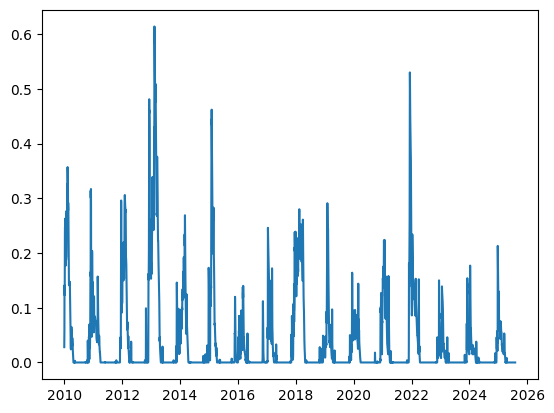

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pdf.DATE, pdf.HTEURNEIGE_Q)

In [57]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

pdf_long = pdf.rename(columns={"DATE": "timestamp", "HTEURNEIGE_Q": "target"})

# If you only have one time series, assign a constant item_id:
pdf_long["item_id"] = "H1"

# Reorder columns as AutoGluon expects
pdf_long = pdf_long[["item_id", "timestamp", "target"]]
train_df = pdf_long.iloc[:-365, :]
test_df = pdf_long.iloc[-365:, :] 

train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    timestamp_column="timestamp"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    timestamp_column="timestamp"
)

train_data.head()

target
item_id timestamp         
H1      2010-01-01   0.028
        2010-01-02   0.040
        2010-01-03   0.060
        2010-01-04   0.141
        2010-01-05   0.130

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length= 1*365,
    path="autogluon-m4-yearly",
    target="target",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/leochaussy/dfg/autogluon-m4-yearly'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          20
GPU Count:          1
Memory Avail:       11.20 GB / 15.46 GB (72.5%)
Disk Space Avail:   920.77 GB / 1006.85 GB (91.4%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 365,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 5326 rows, 1

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
H1      2024-08-01  0.000120 -0.001004 -0.000449 -0.000140 -0.000011   
        2024-08-02  0.000073 -0.001275 -0.000698 -0.000390 -0.000124   
        2024-08-03 -0.000004 -0.001404 -0.000793 -0.000448 -0.000194   
        2024-08-04 -0.000044 -0.001369 -0.000776 -0.000453 -0.000193   
        2024-08-05  0.000013 -0.001293 -0.000741 -0.000454 -0.000200   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
H1      2024-08-01  0.000120  0.000229  0.000308  0.000424  0.000390  
        2024-08-02  0.000073  0.000202  0.000354  0.000442  0.000590  
        2024-08-03 -0.000004  0.000139  0.000264  0.000409  0.000514  
        2024-08-04 -0.000044  0.000078  0.000257  0.000397  0.000703  
        2024-08-05  0.000013  0.000118  0.000279  0.000417  0.000565

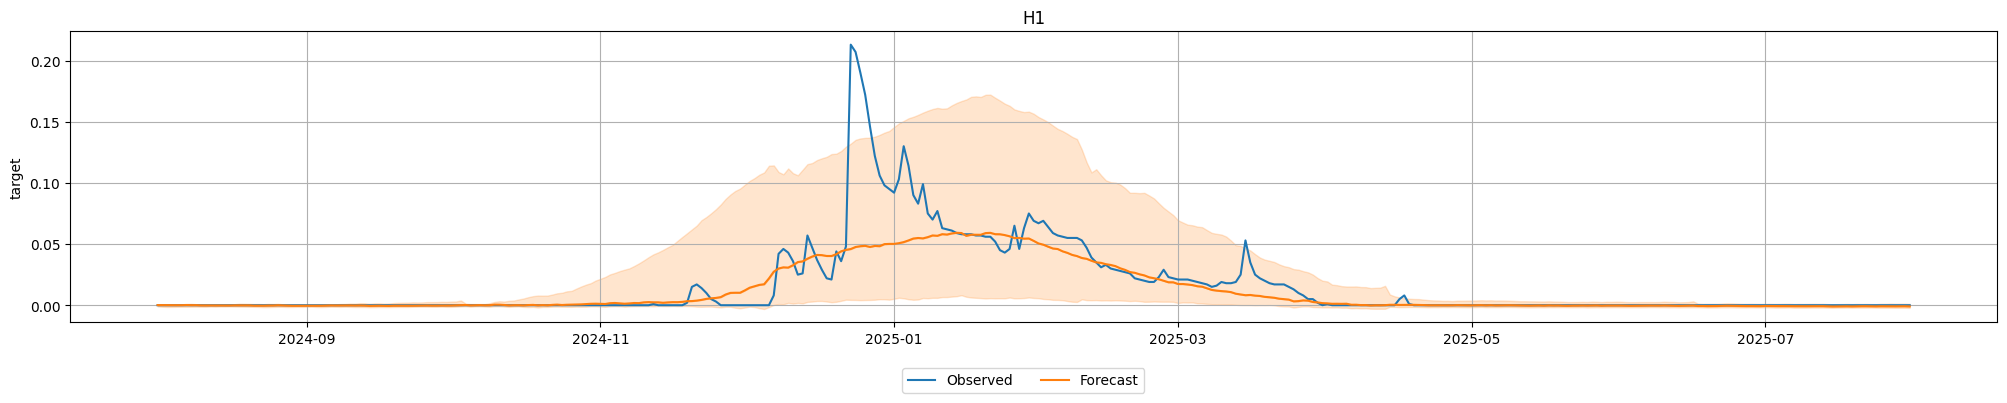

In [ ]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length= 365)